In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
df = pd.read_excel("Online Retail.xlsx")
#df.describe()
df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [39]:
df = df.dropna(subset="CustomerID")
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
df = df[df['Quantity'] > 0]
df['TotalPrice'] = df['Quantity']*df['UnitPrice']
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [40]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
reference_date = df['InvoiceDate'].max()+pd.Timedelta(days=1)
rfm= df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'InvoiceNo' : 'nunique',
    'TotalPrice':sum
}
).reset_index()

/tmp/ipython-input-3424847036.py:3: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  rfm= df.groupby('CustomerID').agg({


In [41]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [42]:
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']


In [43]:
from sklearn.preprocessing import StandardScaler
X = rfm[['Recency', 'Frequency', 'Monetary']]
scaler=StandardScaler()
X_scaled =  scaler.fit_transform(X)

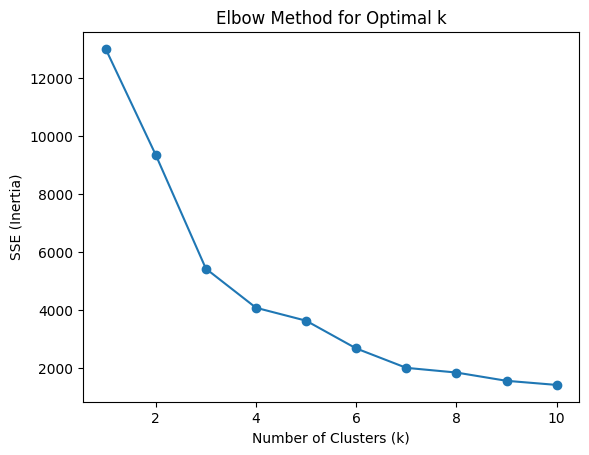

In [44]:
from sklearn.cluster import KMeans
sse=[]
for k in range(1,11):
  km = KMeans(n_clusters=k, random_state=42)
  km.fit(X_scaled)
  sse.append(km.inertia_)
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('SSE (Inertia)')
plt.title('Elbow Method for Optimal k')
plt.show()

In [45]:
kmeans=KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(X_scaled)

In [46]:
rfm

,CustomerID,Recency,Frequency,Monetary,Cluster
0,12346.0,326,1,77183.60,0
1,12347.0,2,7,4310.00,3
2,12348.0,75,4,1797.24,3
3,12349.0,19,1,1757.55,3
4,12350.0,310,1,334.40,1
...,...,...,...,...,...
4334,18280.0,278,1,180.60,1
4335,18281.0,181,1,80.82,1
4336,18282.0,8,2,178.05,3
4337,18283.0,4,16,2094.88,0


In [47]:
cluster_summary = (
    rfm.groupby('Cluster')
       .agg({'Recency':'mean',
             'Frequency':'mean',
             'Monetary':'mean',
             'CustomerID':'count'})
       .rename(columns={'CustomerID':'Num_Customers'})
)


In [48]:
cluster_summary

,Recency,Frequency,Monetary,Num_Customers
Cluster,,,,
0,15.672986,22.047393,12453.225924,211
1,248.564030,1.551789,478.107581,1062
2,7.384615,82.692308,127338.313846,13
3,43.910580,3.655748,1349.698298,3053


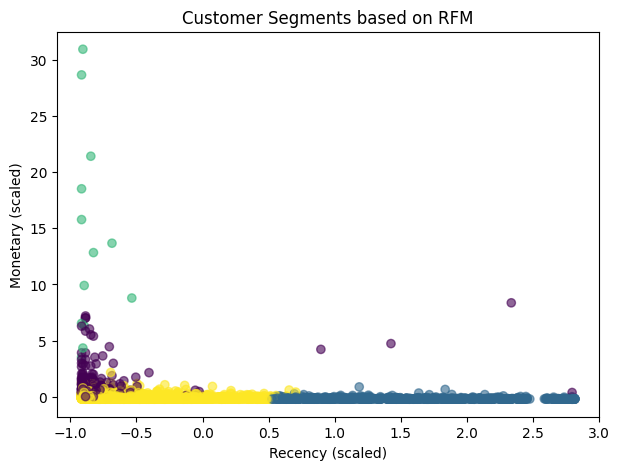

In [49]:
plt.figure(figsize=(7,5))
plt.scatter(X_scaled[:,0], X_scaled[:,2],
            c=rfm['Cluster'], cmap='viridis', alpha=0.6)
plt.xlabel('Recency (scaled)')
plt.ylabel('Monetary (scaled)')
plt.title('Customer Segments based on RFM')
plt.show()


In [50]:
from sklearn.metrics import silhouette_score
score = silhouette_score(X_scaled, rfm['Cluster'])
print(f"Silhouette Score: {score:.3f}")

Silhouette Score: 0.616


Silhouette Score ranges from −1 to +1.

Closer to 1 → clusters are dense and well-separated.

Near 0 → overlap.

Negative → misclassification.

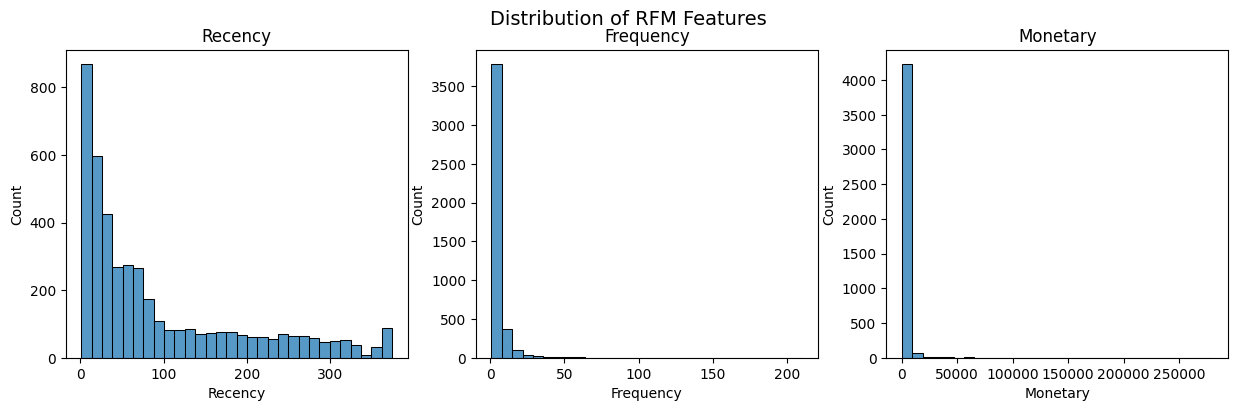

In [51]:
fig, ax = plt.subplots(1,3, figsize=(15,4))
sns.histplot(rfm['Recency'], bins=30, ax=ax[0])
sns.histplot(rfm['Frequency'], bins=30, ax=ax[1])
sns.histplot(rfm['Monetary'], bins=30, ax=ax[2])
ax[0].set_title('Recency')
ax[1].set_title('Frequency')
ax[2].set_title('Monetary')
plt.suptitle('Distribution of RFM Features', fontsize=14)
plt.show()


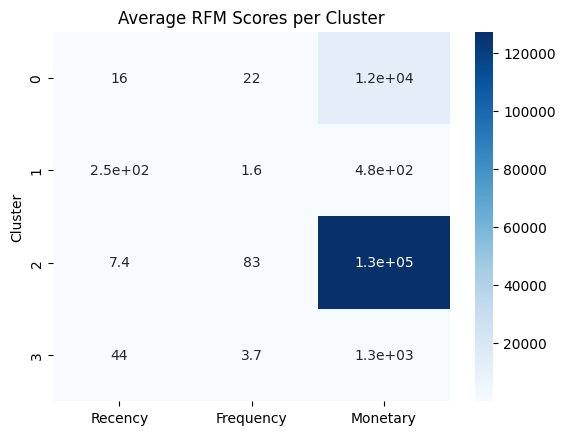

In [52]:
cluster_heatmap = (
    rfm.groupby('Cluster')[['Recency','Frequency','Monetary']]
    .mean()
    .round(1)
)
sns.heatmap(cluster_heatmap, annot=True, cmap='Blues')
plt.title('Average RFM Scores per Cluster')
plt.show()


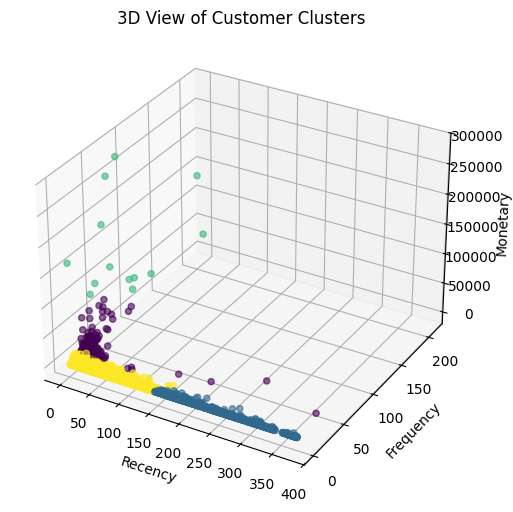

In [53]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rfm['Recency'], rfm['Frequency'], rfm['Monetary'],
           c=rfm['Cluster'], cmap='viridis', alpha=0.6)
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.title('3D View of Customer Clusters')
plt.show()


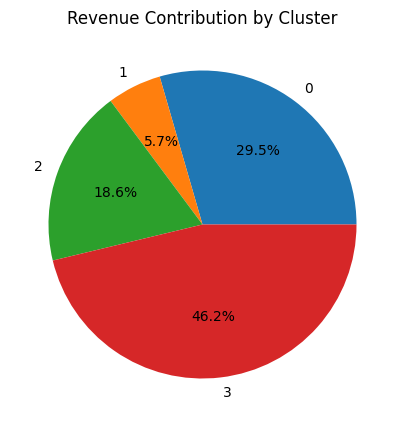

In [54]:
rfm['Revenue'] = rfm['Monetary']
share = rfm.groupby('Cluster')['Revenue'].sum()
share.plot(kind='pie', autopct='%1.1f%%', figsize=(5,5))
plt.title('Revenue Contribution by Cluster')
plt.ylabel('')
plt.show()


<Axes: ylabel='Cluster'>

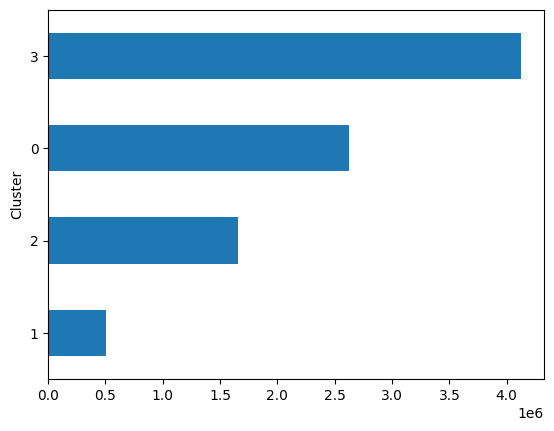

In [55]:
share.sort_values().plot(kind='barh')


### Customer Segment Insights
- **Cluster 0 – Champions:** recent, frequent, high-spend. Treat as VIPs.
- **Cluster 1 – Risky:** long time since purchase; win-back offers.
- **Cluster 2 – Regular:** steady; consider subscriptions/bundles.
- **Cluster 3 – Potential Growth:** new/low-spend; onboarding + upsell.
